In [1]:
import gym
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from copy import deepcopy
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import transforms



In [2]:
env = gym.make('CartPole-v0').unwrapped

In [3]:
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor

In [4]:
Transition = namedtuple('Transition',
                        ('state', 
                         'action', 
                         'next_state', 
                         'reward'))

In [5]:
resize_img = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(40, interpolation=Image.CUBIC),
    transforms.ToTensor()
    ])

screen_width = 600  # this is default parameter in gym


In [6]:
def get_cart_location():
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)


In [7]:
def get_screen():
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    #print(screen.shape)
    screen = screen[:, 160:320]
    #print(screen.shape)
    view_width = 320
    cart_location = get_cart_location()
    #print(cart_location,view_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)

    screen = screen[:, :, slice_range]
    #print(screen.shape)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    #print(resize_img(screen).unsqueeze(0).type(FloatTensor).shape)
    return resize_img(screen).unsqueeze(0).type(FloatTensor)



In [8]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200


In [9]:
class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Save a transition"""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

memory = ReplayMemory(10000)

In [10]:
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.conv_bn1 = nn.Sequential(
            nn.Conv2d(3, 16, 5, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(True)
        )
        self.conv_bn2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(True)
        )
        self.conv_bn3 = nn.Sequential(
            nn.Conv2d(32, 32, 5, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(True)
        )
        self.move = nn.Linear(448, 2)

    def forward(self, x):
        x = self.conv_bn1(x)
        x = self.conv_bn2(x)
        x = self.conv_bn3(x)
        x = x.view(x.size(0), -1)
        x = self.move(x)
        return x

model = DQN()
if use_cuda:
    model.cuda()

In [11]:
steps_done = 0
def select_action(state):
    global steps_done
    sample = random.random()
    #print(sample)
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1 * steps_done / EPS_DECAY)
    #print(eps_threshold )
    steps_done += 1
    if sample > eps_threshold:
        return model(state.type(FloatTensor)).data.max(1)[1]
    else:
        return LongTensor([random.randrange(2)])


In [12]:
optimizer = optim.RMSprop(model.parameters())

last_sync = 0
def optimize_model():
    global last_sync
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = ByteTensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)))
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch =torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    

    state_action_values = model(state_batch).gather(1, action_batch.unsqueeze(1))

    next_state_values = torch.zeros(BATCH_SIZE).type(FloatTensor)
    next_state_values[non_final_mask] = model(non_final_next_states).max(1)[0]

    # next_state_values.volatile = False

    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values)

    #with torch.no_grad():
    loss.backward()
    for param in model.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()



In [13]:
episode_durations = []
def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.FloatTensor(episode_durations)
    #print(durations_t)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())

    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        plt.plot(means.numpy())

    plt.pause(0.001)


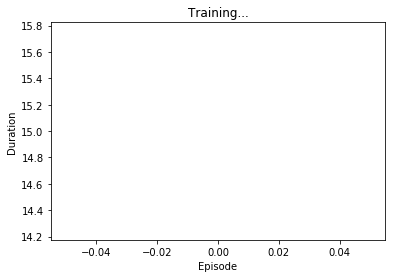

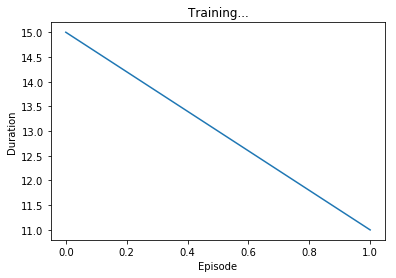

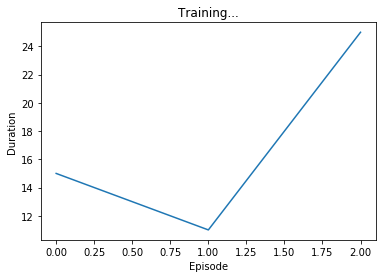

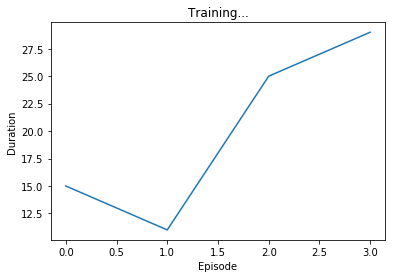

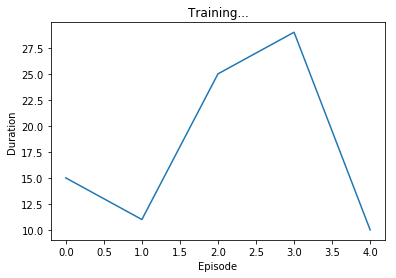

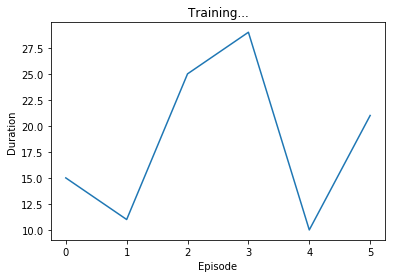

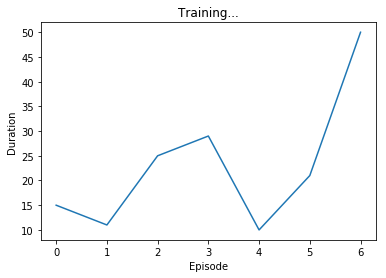

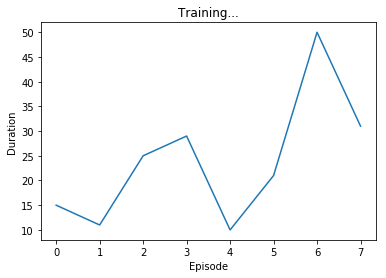

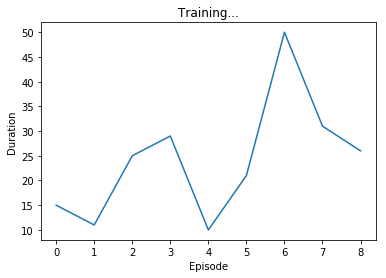

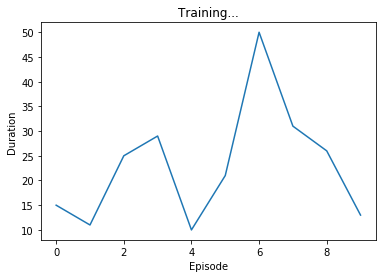

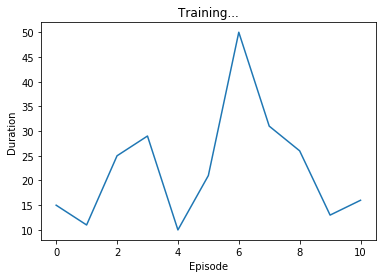

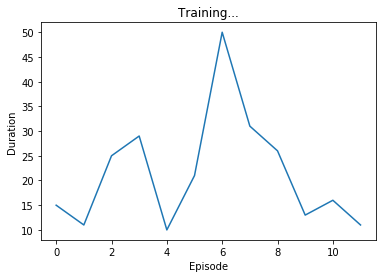

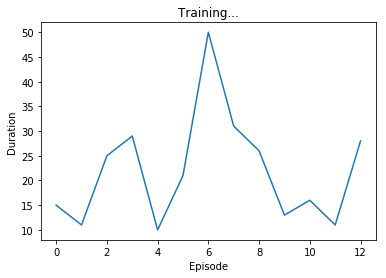

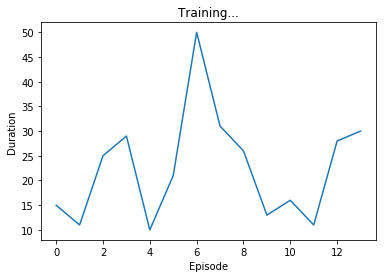

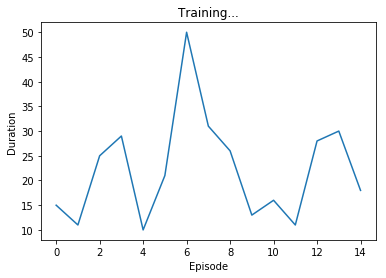

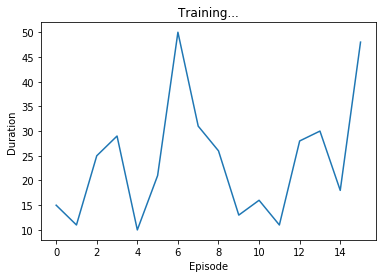

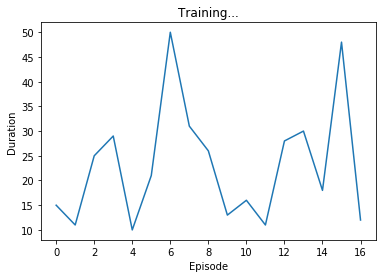

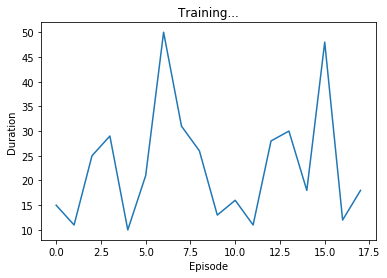

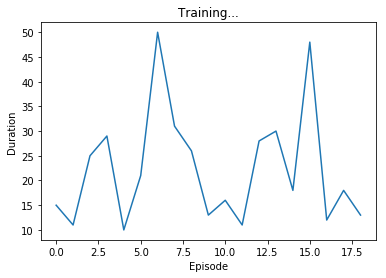

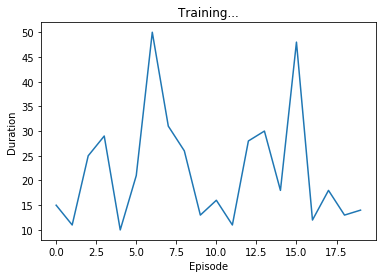

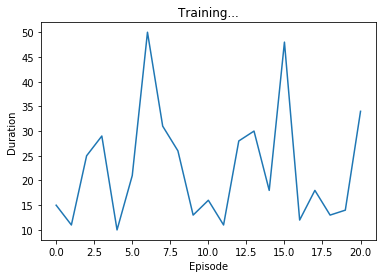

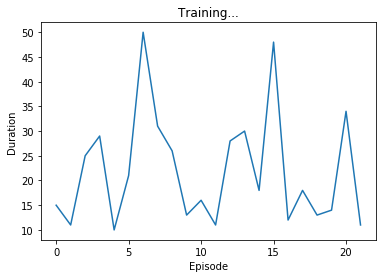

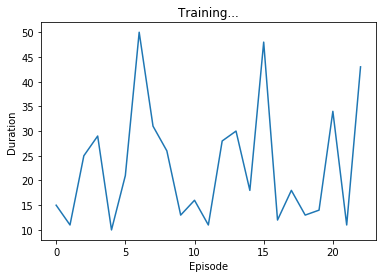

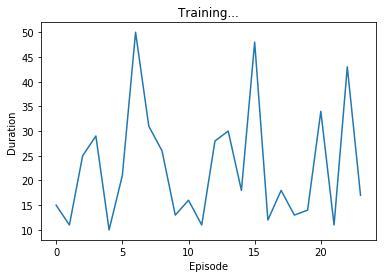

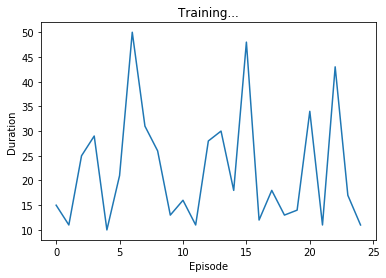

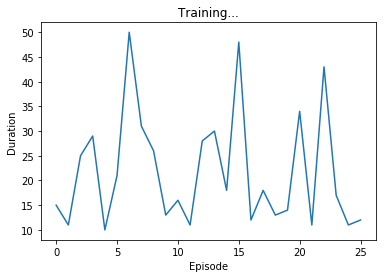

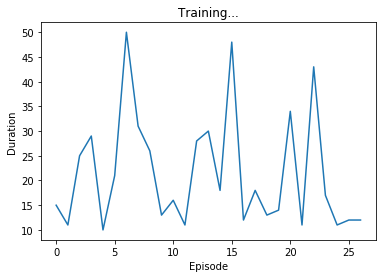

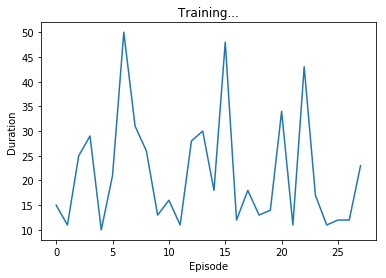

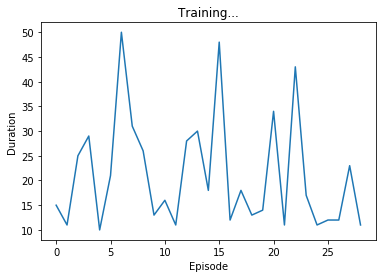

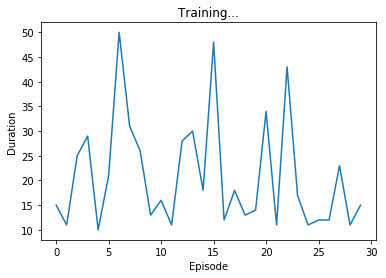

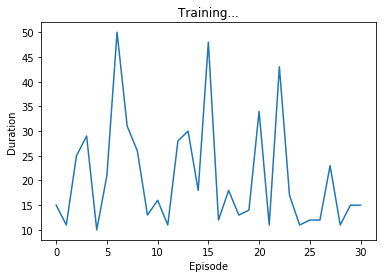

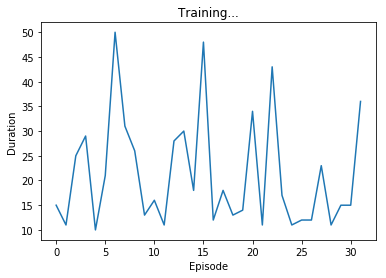

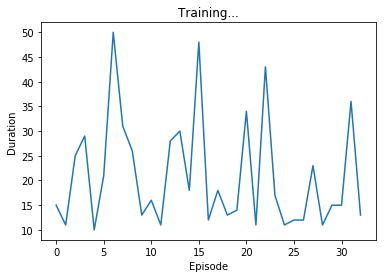

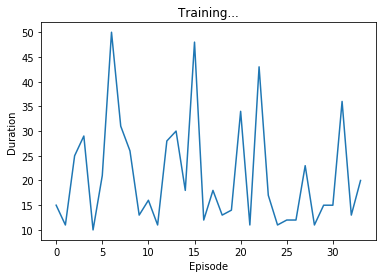

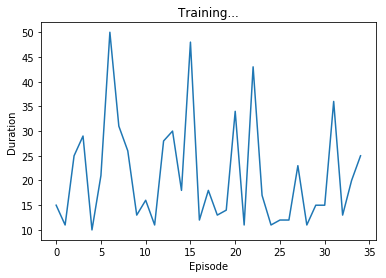

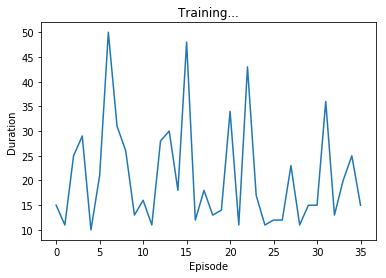

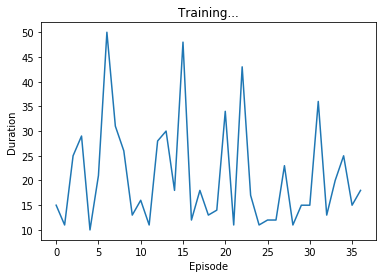

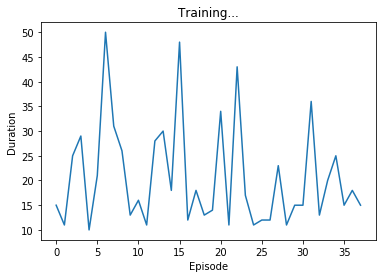

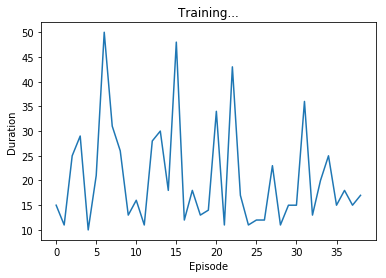

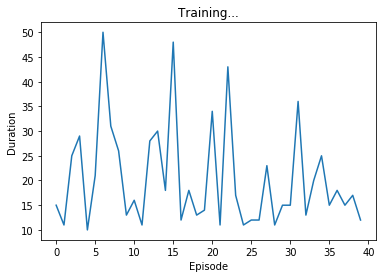

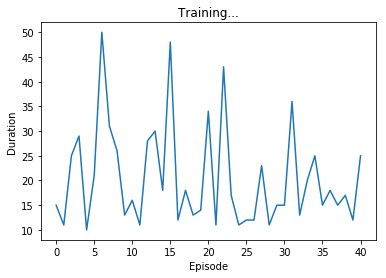

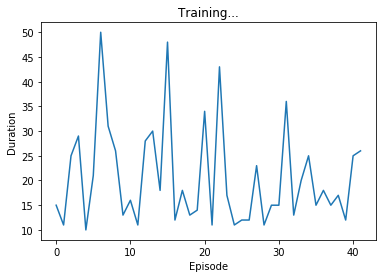

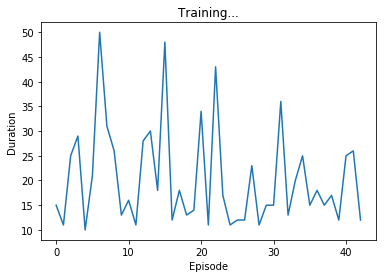

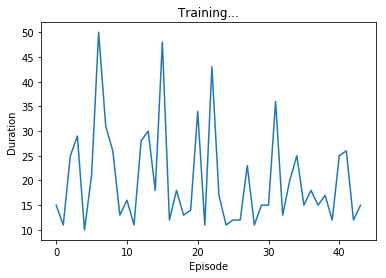

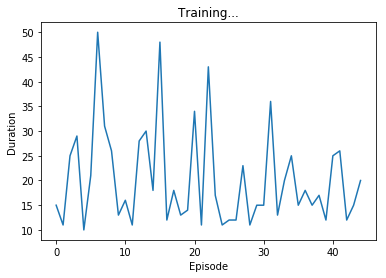

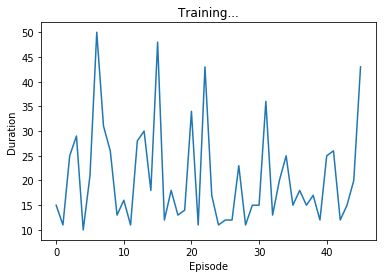

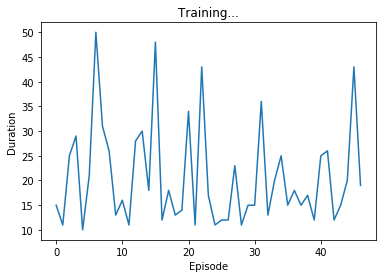

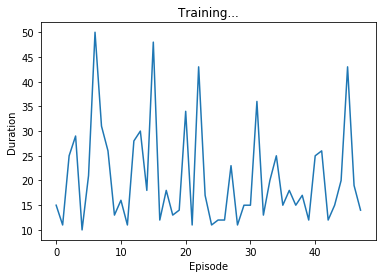

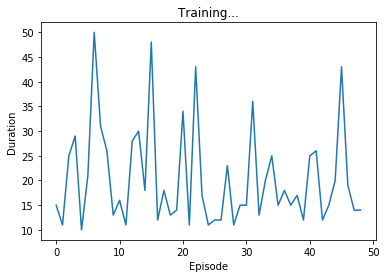

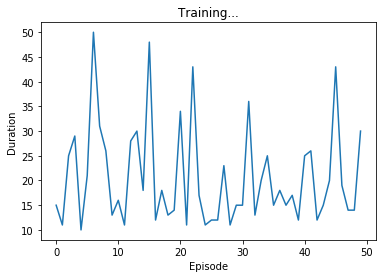

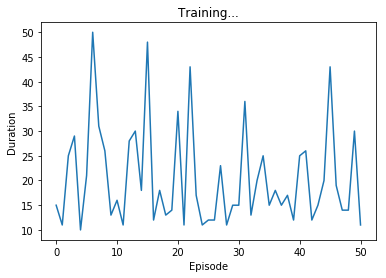

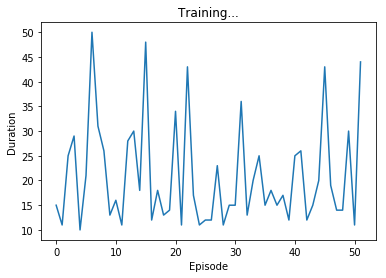

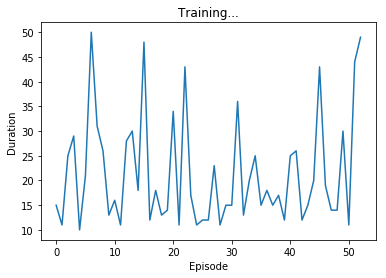

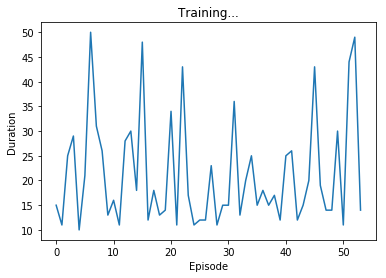

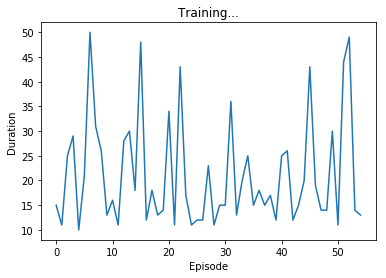

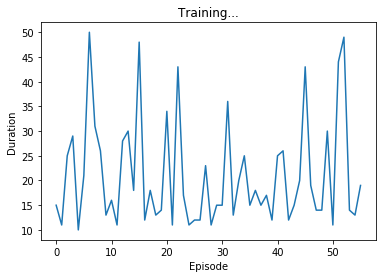

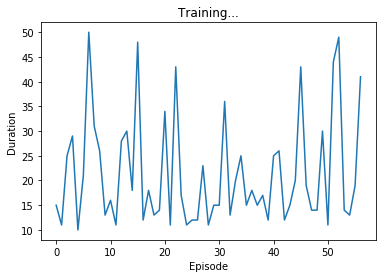

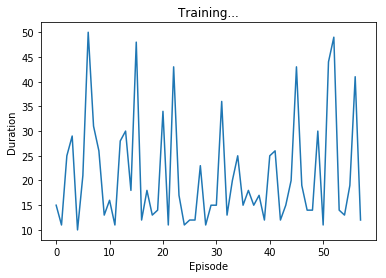

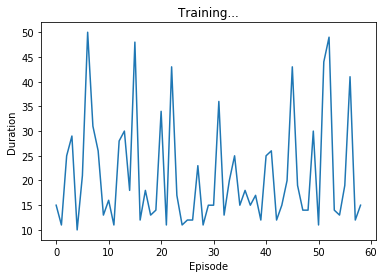

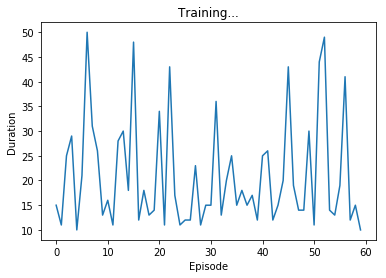

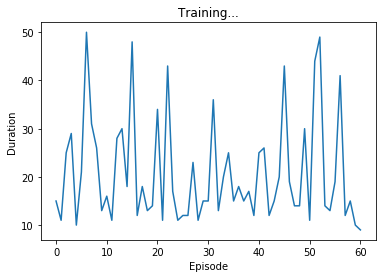

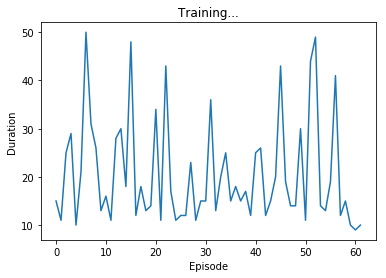

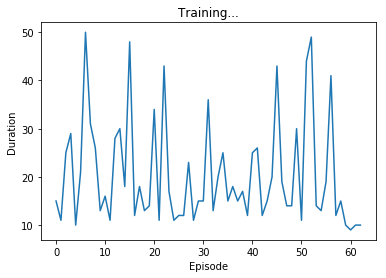

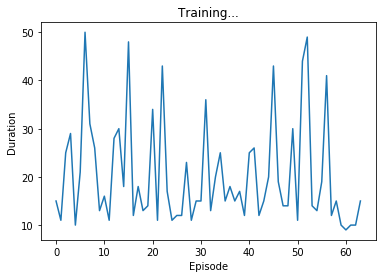

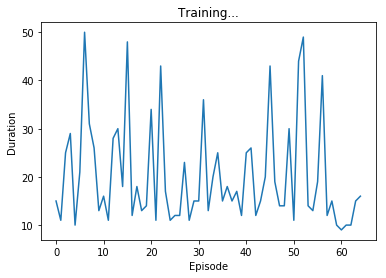

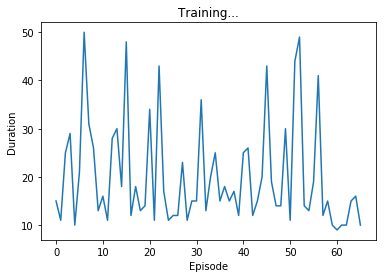

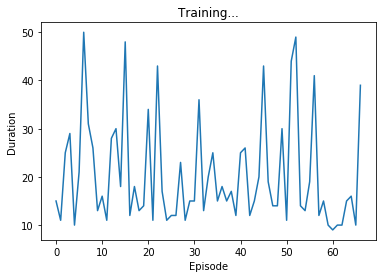

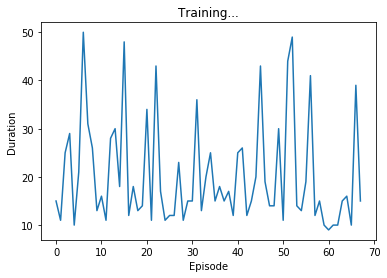

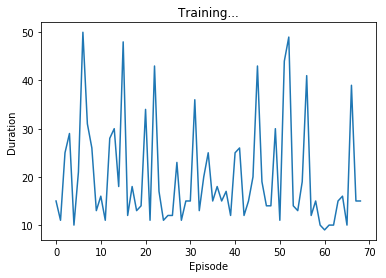

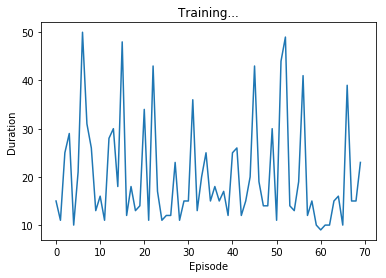

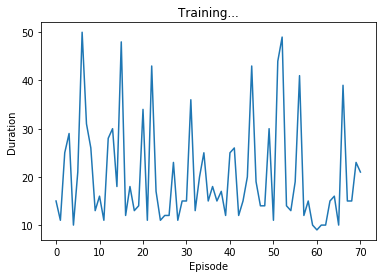

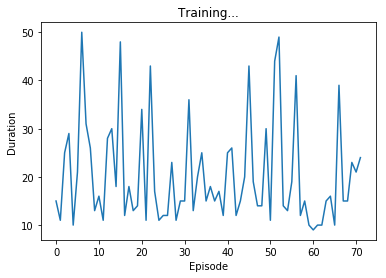

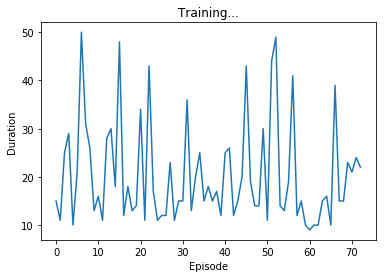

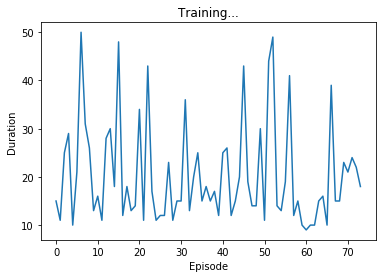

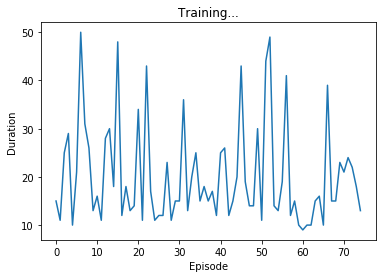

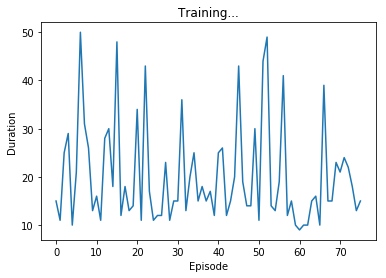

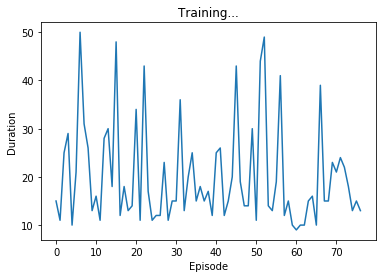

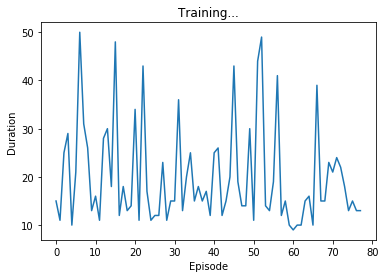

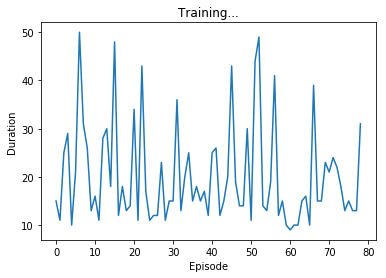

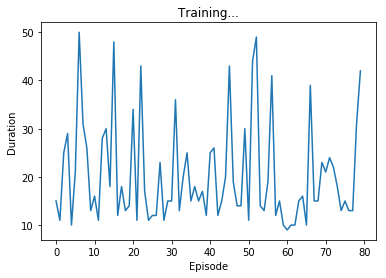

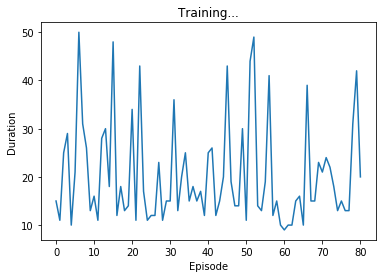

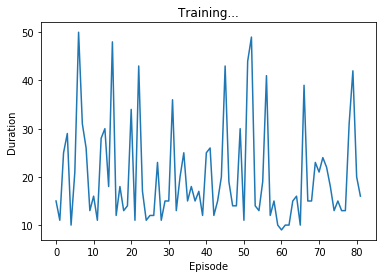

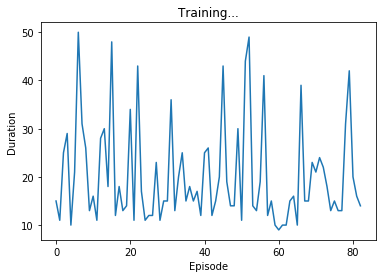

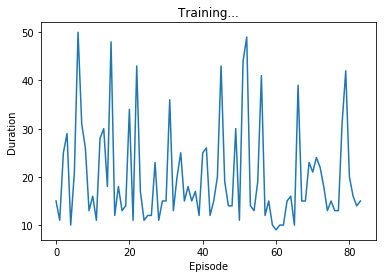

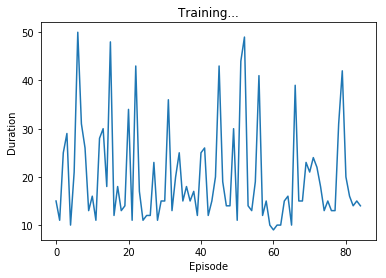

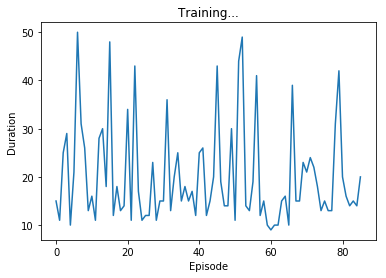

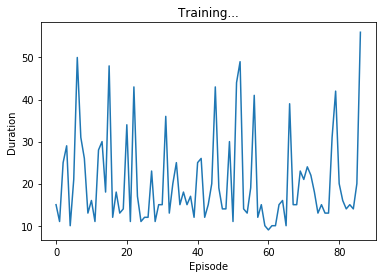

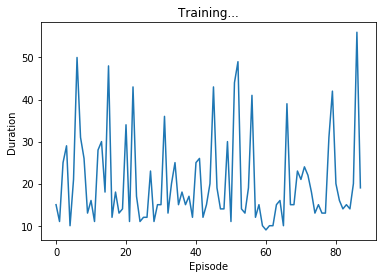

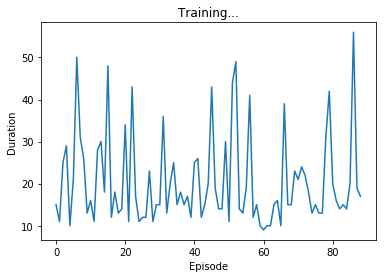

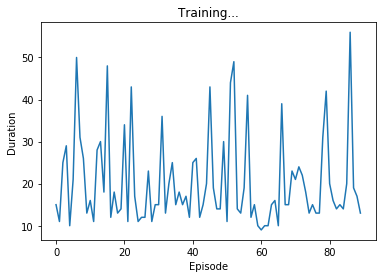

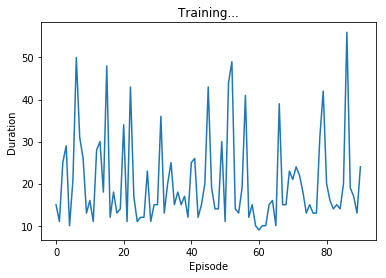

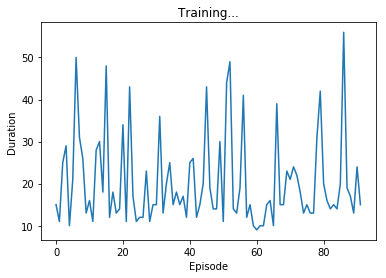

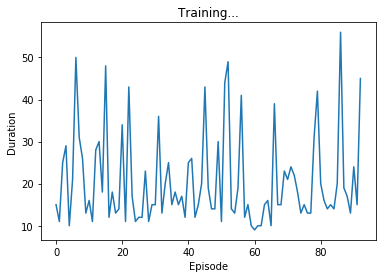

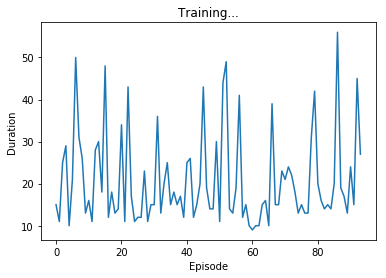

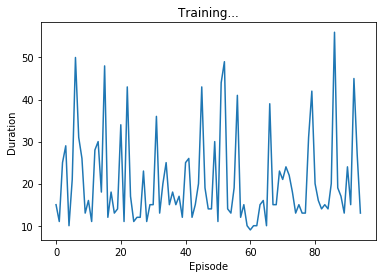

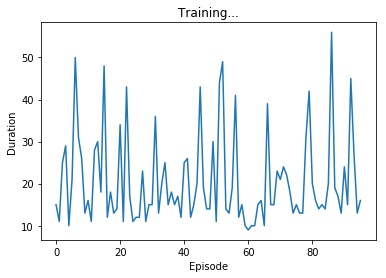

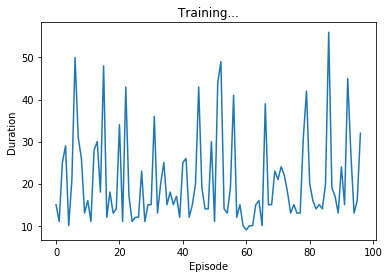

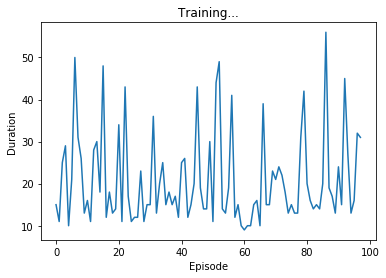

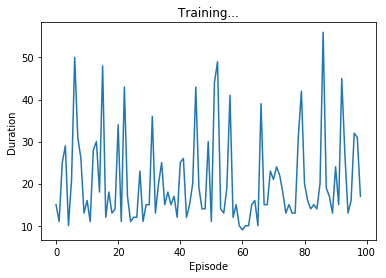

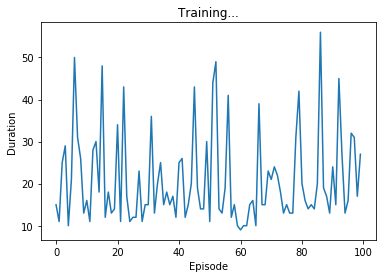

Complete


TypeError: render() got an unexpected keyword argument 'close'

In [14]:
num_episodes = 100
for i_episode in range(num_episodes):
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        action = select_action(state)
        _, reward, done, _ = env.step(int(action[0]))
        reward = FloatTensor([reward])

        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            #print("over")
            next_state = None

        memory.push(state, action, next_state, reward)

        state = next_state

        optimize_model()
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
env.render(S)
env.close()
plt.ioff()
plt.show()